In [ ]:
## for plotting SSH / ocean color underway with ship track 

In [8]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from os import listdir
import glob
import os
import pandas as pd
import imageio
import scipy
from netCDF4 import Dataset
import datetime as dt
import cartopy.crs as ccrs

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy
import earthaccess
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import os
import netCDF4 
import fnmatch


from matplotlib.animation import FuncAnimation, PillowWriter  
import matplotlib.colors as mcolors

## Accessing NASA Ocean color files from shared drive 

In [27]:
# sort the files by date 

path = '/home/vboatwright/mnt/scienceparty_share/SR2503_scienceparty_share/SAT/L3m_CHL_NRT_StLucia/' # change to path to scienceshare on your local computer 
path = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L3m_CHL_NRT_StLucia/'
files = os.listdir(path)

# readable files: 
readable_files = []

for nc_file in files:
    try:
        with netCDF4.Dataset(path+nc_file, "r") as ds:
            readable_files.append(nc_file)
    except OSError as e:
        if "HDF error" in str(e):
            print(f"Skipping {nc_file} due to HDF error.")
        else:
            print(f"Skipping {nc_file} due to unexpected error: {e}")
    except Exception as e:
        print(f"Skipping {nc_file} due to general error: {e}")

# dates are sorted for these at characters 11:19 
sorted_files = sorted(readable_files, key=lambda x: x[11:19])



Skipping AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.4km.NRT.nc due to HDF error.
Skipping AQUA_MODIS.20250218_20250225.L3m.8D.CHL.chlor_a.4km.NRT.nc due to HDF error.
Skipping AQUA_MODIS.20250202.L3m.DAY.CHL.chlor_a.4km.NRT.nc due to HDF error.
Skipping AQUA_MODIS.20250202_20250209.L3m.8D.CHL.chlor_a.4km.NRT.nc due to HDF error.
Skipping AQUA_MODIS.20250222.L3m.DAY.CHL.chlor_a.4km.NRT.nc due to HDF error.
Skipping AQUA_MODIS.20250210_20250217.L3m.8D.CHL.chlor_a.4km.NRT.nc due to HDF error.
Skipping AQUA_MODIS.20250201.L3m.DAY.CHL.chlor_a.4km.NRT.nc due to HDF error.


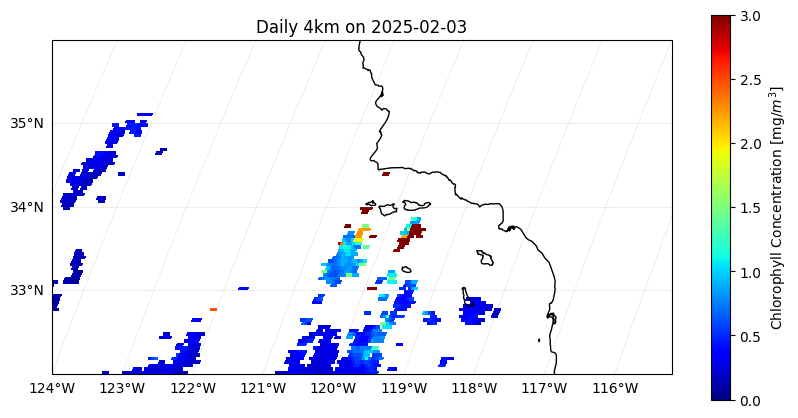

In [11]:
## animate 

import matplotlib.animation as animation
import cartopy.crs as ccrs
import matplotlib.ticker as mticker


# select for only the desired timestep satellite grabs 

daily9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*DAY*9km*.nc')]
daily4km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*DAY*4km*.nc')]
comp8d_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*9km*.nc')]


# now perform for each day satellite file that i have 

# set bounds
xmin, xmax = -124, -117
ymin, ymax = 32, 36
sdlonlat = [-117.24556, 32.928333]
chl_extent = [0, 3]

# loop through all valid files
chl_data = []
titles = []
lon, lat = None, None  

res = '4km' # 9 or 4 km 
for ff in daily4km_files[-1]:
    dataset = xr.open_dataset(path+ff)
    chl = dataset["chlor_a"]
    if lon is None or lat is None:
        lon, lat = np.meshgrid(dataset["lon"], dataset["lat"])
    chl_data.append(chl.values)
    given_date = datetime.strptime(dataset.attrs.get("product_name", ff)[11:19], "%Y%m%d")
    titles.append(f'Daily {res} on {given_date.strftime("%Y-%m-%d")}')  

# check if we loaded data
if not chl_data:
    raise ValueError("No valid chlorophyll data found.")


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
crs_data = ccrs.PlateCarree()

# create empty plot for animation 
mesh = ax.pcolormesh(lon, lat, chl_data[0], cmap="jet", vmin=chl_extent[0], vmax=chl_extent[1], transform=crs_data)
# log scale plot: 
# change mins: 
#chl_extent = [1e-2, 3]
#mesh = ax.pcolormesh(lon,lat,chl_data[0],cmap='jet',transform=crs_data,norm=mcolors.LogNorm(vmin=chl_extent[0],vmax=chl_extent[1]) )
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(r'Chlorophyll Concentration [mg/$m^3$]')

ax.set_extent((xmin, xmax, ymin, ymax))
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0.2, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MultipleLocator(1)
gl.ylocator = mticker.MultipleLocator(1)

# reference SD 
ax.scatter(sdlonlat[0], sdlonlat[1], color="red", marker="*", label="SD")
title = ax.set_title(titles[0])

# update animation via function
def update(frame):
    mesh.set_array(chl_data[frame].ravel())  # update pcolormesh data
    title.set_text(titles[frame])  # update title
    return mesh, title

ani = animation.FuncAnimation(fig, update, frames=len(chl_data), interval=500, blit=False)
plt.show()

# save as GIF
#save_loc = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/at_sea/'
#ani.save(save_loc+'santalucia_daily_aquamodis_'+res+'.gif', writer="pillow", fps=1)

# save as MP4 - not currently loaded correctly
# ani.save("chlorophyll_animation.mp4", writer="ffmpeg", fps=5)




In [ ]:
comp8d9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*9km*.nc')][0]



In [199]:
comp8d9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*.nc')]

comp8d9km_files

['AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.9km.NRT.nc',
 'AQUA_MODIS.20250202_20250209.L3m.8D.CHL.chlor_a.9km.NRT.nc',
 'AQUA_MODIS.20250210_20250217.L3m.8D.CHL.chlor_a.9km.NRT.nc']

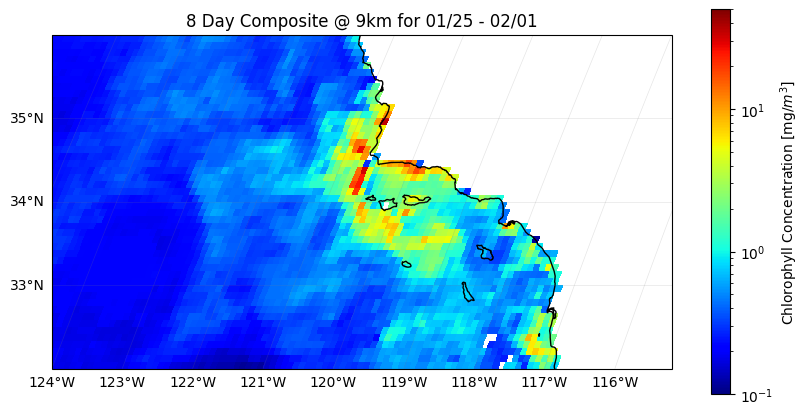

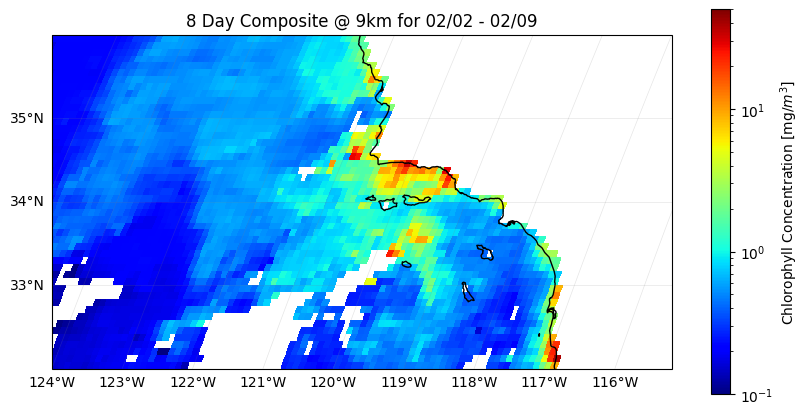

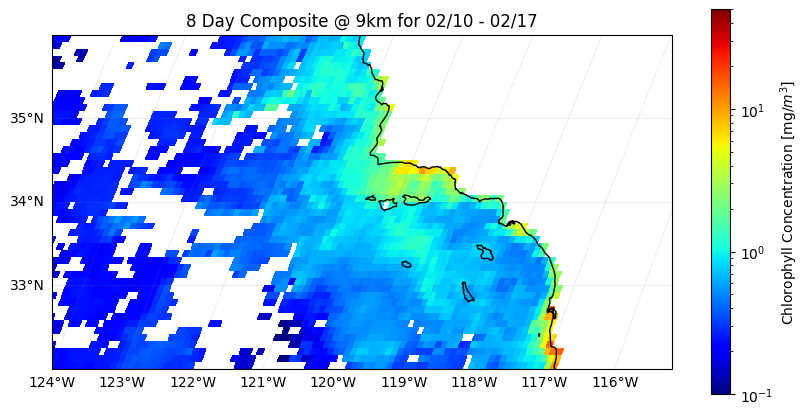

In [24]:
comp8d9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*9km*.nc')]
dataset = xr.open_dataset(path+ff) 
chl = dataset["chlor_a"]
clon, clat = np.meshgrid(dataset["lon"], dataset["lat"])
chl_extent = [1e-1,50]

crs_proj = cartopy.crs.Robinson()
crs_data = cartopy.crs.PlateCarree()

# loop through each 8day composite 

# set bounds
xmin, xmax = -124, -117
ymin, ymax = 32, 36
sdlonlat = [-117.24556, 32.928333]
chl_extent = [1e-1,50]


for ff in comp8d9km_files: 
    dataset = xr.open_dataset(path+ff) 
    chl = dataset["chlor_a"]
    clon, clat = np.meshgrid(dataset["lon"], dataset["lat"])
       
    crs_proj = cartopy.crs.Robinson()
    crs_data = cartopy.crs.PlateCarree()
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(projection=crs_proj)
    # mesh = ax.pcolormesh(lon, lat, chl, cmap="jet", transform=crs_data) #, vmin=chl_extent[0], vmax=chl_extent[1])
    mesh = ax.pcolormesh(clon,clat,chl,cmap='jet',transform=crs_data,norm=mcolors.LogNorm(vmin=chl_extent[0],vmax=chl_extent[1]) )

    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(r'Chlorophyll Concentration [mg/$m^3$]')
    ax.set_extent((xmin,xmax,ymin,ymax))
    ax.coastlines()
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.2, linestyle='-')  
    gl.top_labels = False; gl.right_labels = False 
    gl.xlocator = mticker.MultipleLocator(1) 
    gl.ylocator = mticker.MultipleLocator(1) 
    d0 = datetime.strptime(dataset.attrs.get("product_name", ff)[11:19], "%Y%m%d")
    d1 = datetime.strptime(dataset.attrs.get("product_name", ff)[20:28], "%Y%m%d")
    ax.set_title(f'8 Day Composite @ 9km for {d0.strftime("%m/%d")} - {d1.strftime("%m/%d")}')
    plt.show()



In [ ]:
# nice! next we will access the ship data in order to get ship location as we go 

### Access ship data from cruise drive


In [33]:
# location of cruise folder on my local computer 
shipinfo = '/home/vboatwright/mnt/cruise/SR2503/metacq/data/'

seadates = [dt.datetime(2025,2,19),dt.datetime(2025,2,20),dt.datetime(2025,2,21),dt.datetime(2025,2,22),dt.datetime(2025,2,23),dt.datetime(2025,2,24),dt.datetime(2025,2,25)]
longdays = [sd.strftime("%Y%m%d") for sd in seadates]
days = [sd.strftime("%y%m%d") for sd in seadates]
time = [int(dd) for dd in longdays]

NN = len(days) 
slons = []
slats = []

for ii in np.arange(0,NN): 
    shipdata = np.loadtxt(shipinfo+days[ii]+'.MET',usecols=(0,24,25))
    if shipdata[1,2]>0 or shipdata[1,2]<-100:
        shipdata=np.loadtxt(shipinfo+days[ii]+'.MET',usecols=(0,24,25))
    metatime=min(shipdata[:,0], key=lambda x:abs(x-time[ii]))
    subset=shipdata[shipdata[:,0]==metatime,:]
    lat,lon=subset[0,1:3]
    slons.append(lon)
    slats.append(lat)



In [35]:
seadates

[datetime.datetime(2025, 2, 19, 0, 0),
 datetime.datetime(2025, 2, 20, 0, 0),
 datetime.datetime(2025, 2, 21, 0, 0),
 datetime.datetime(2025, 2, 22, 0, 0),
 datetime.datetime(2025, 2, 23, 0, 0),
 datetime.datetime(2025, 2, 24, 0, 0),
 datetime.datetime(2025, 2, 25, 0, 0)]

IndexError: list index out of range

/home/vboatwright/python_environments/sio/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/vboatwright/python_environments/sio/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/vboatwright/python_environments/sio/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vboatwright/python_environments/sio/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making fig

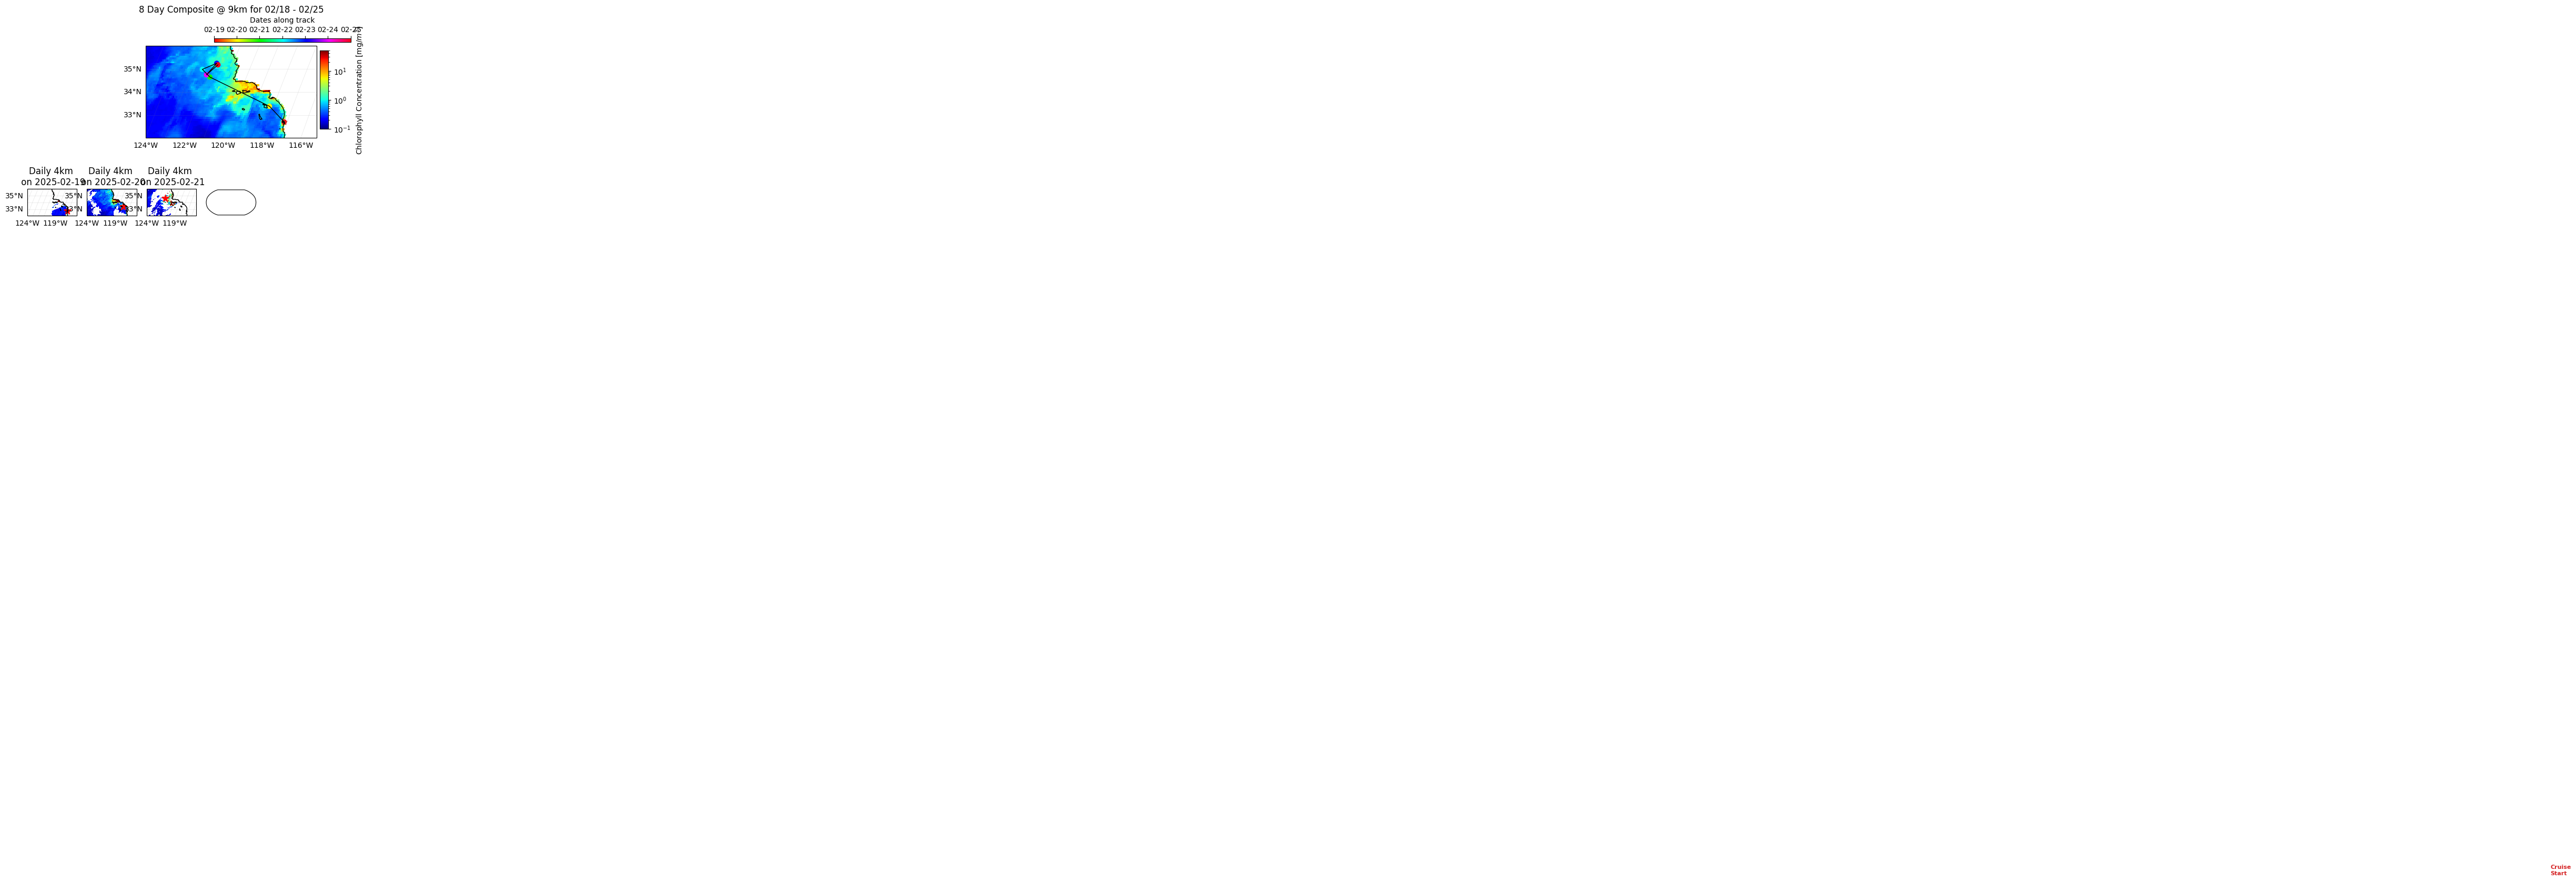

In [37]:

fig = plt.figure(figsize=(10,5), layout="constrained")
numdays = NN 
numday = np.arange(0,NN)
spec = fig.add_gridspec(2,numdays)

cmaps = ['RdBu_r', 'viridis']

# set bounds
xmin, xmax = -124, -117
ymin, ymax = 32, 36
sdlonlat = [-117.24556, 32.928333]

comp8d9km_file = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*9km*.nc')][-1]
dataset = xr.open_dataset(path+comp8d9km_file) 
chl = dataset["chlor_a"]
clon, clat = np.meshgrid(dataset["lon"], dataset["lat"])
chl_extent = [1e-1,50]

crs_proj = cartopy.crs.Robinson()
crs_data = cartopy.crs.PlateCarree()

# consolidate top row for 8day composite map 
ax0 = fig.add_subplot(spec[0, :],projection=crs_proj)

# mesh = ax.pcolormesh(lon, lat, chl, cmap="jet", transform=crs_data) #, vmin=chl_extent[0], vmax=chl_extent[1])
mesh = ax0.pcolormesh(clon,clat,chl,cmap='jet',transform=crs_data,norm=mcolors.LogNorm(vmin=chl_extent[0],vmax=chl_extent[1]) )

cax0 = ax0.inset_axes([1.02, 0.1, 0.05, 0.85]) # [left, bottom, width, height]
chlcbar = fig.colorbar(mesh, cax=cax0,orientation='vertical')
chlcbar.set_label(r'Chlorophyll Concentration [mg/$m^3$]')
ax0.set_extent((xmin,xmax,ymin,ymax))
ax0.coastlines()

gl = ax0.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.2, linestyle='-')  
gl.top_labels = False; gl.right_labels = False 
gl.xlocator = mticker.MultipleLocator(1) 
gl.ylocator = mticker.MultipleLocator(1) 

d0 = datetime.strptime(dataset.attrs.get("product_name", comp8d9km_file)[11:19], "%Y%m%d")
d1 = datetime.strptime(dataset.attrs.get("product_name", comp8d9km_file)[20:28], "%Y%m%d")
ax0.set_title(f'8 Day Composite @ 9km for {d0.strftime("%m/%d")} - {d1.strftime("%m/%d")}')

# add ship trajectory
numdays = np.arange(0,NN)
j = ax0.plot(slons,slats,linewidth=1,label='Ship Track',color='k',transform=crs_data)
traj = ax0.scatter(slons,slats,c=numdays,s=40,linewidth=1,transform=crs_data,cmap='hsv')

j1 = ax0.scatter(slons[0],slats[0],c='tab:red',marker='*',s=60,transform=crs_data)
ax0.annotate('Cruise\nStart',(slons[0]-0.075,slats[0]-0.25),color='tab:red',fontsize=8,fontweight='bold')


# trajectory colorbar
cax1 = ax0.inset_axes([0.4, 1.04, 0.8, 0.04]) # [left, bottom, width, height]
trajcbar = fig.colorbar(traj, cax=cax1,orientation='horizontal')
cax1.tick_params(axis='both',which='both',right=True,left=False,labelright=True)
cax1.xaxis.set_ticks_position('top'); cax1.xaxis.set_label_position('top') 
dates = [dt.datetime.strftime(d,'%m-%d') for d in seadates]
cax1.xaxis.set_ticks(numdays,labels=dates)
trajcbar.set_label('Dates along track',labelpad=5,fontsize=10)

chl_extent = [0, 3]

# make this automattically detect available files and only plot that number of subplots

for ii in np.arange(0,NN) : 
    ax1 = fig.add_subplot(spec[1,ii],projection=crs_proj)
    datenum = seadates[ii].strftime("%Y%m%d")
    day9kmfile = [f for f in sorted_files if fnmatch.fnmatch(f, f'*{datenum}*DAY*9km*.nc')][0]
    day4kmfile = [f for f in sorted_files if fnmatch.fnmatch(f, f'*{datenum}*DAY*4km*.nc')][0]
    res = '4km'
    file = day4kmfile
    dataset = xr.open_dataset(path+day4kmfile)
    chl = dataset["chlor_a"].values
    clon, clat = np.meshgrid(dataset["lon"], dataset["lat"])
    title = f'Daily {res} \n on {seadates[ii].strftime("%Y-%m-%d")}'
    dayplot = ax1.pcolormesh(clon, clat, chl, cmap="jet", vmin=chl_extent[0], vmax=chl_extent[1], transform=crs_data)

    ax1.set_extent((xmin, xmax, ymin, ymax))
    ax1.coastlines()
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0.2, linestyle="-")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MultipleLocator(1)
    gl.ylocator = mticker.MultipleLocator(1)
    
    # reference ship  
    ax1.scatter(slons[ii], slats[ii], color="red", marker="*", s=100, transform=crs_data)
    ax1.set_title(title)

    if ii == NN : 
        # add colorbar for all plots 
        cax = ax1.inset_axes([0.1, -0.1, 0.65, 0.05]) # [left, bottom, width, height]
        chlcbar = fig.colorbar(dayplot, cax=cax,orientation='horizontal')
        chlcbar.set_label(r'Chlorophyll Concentration \n [mg/m^3]')
        

plt.show()

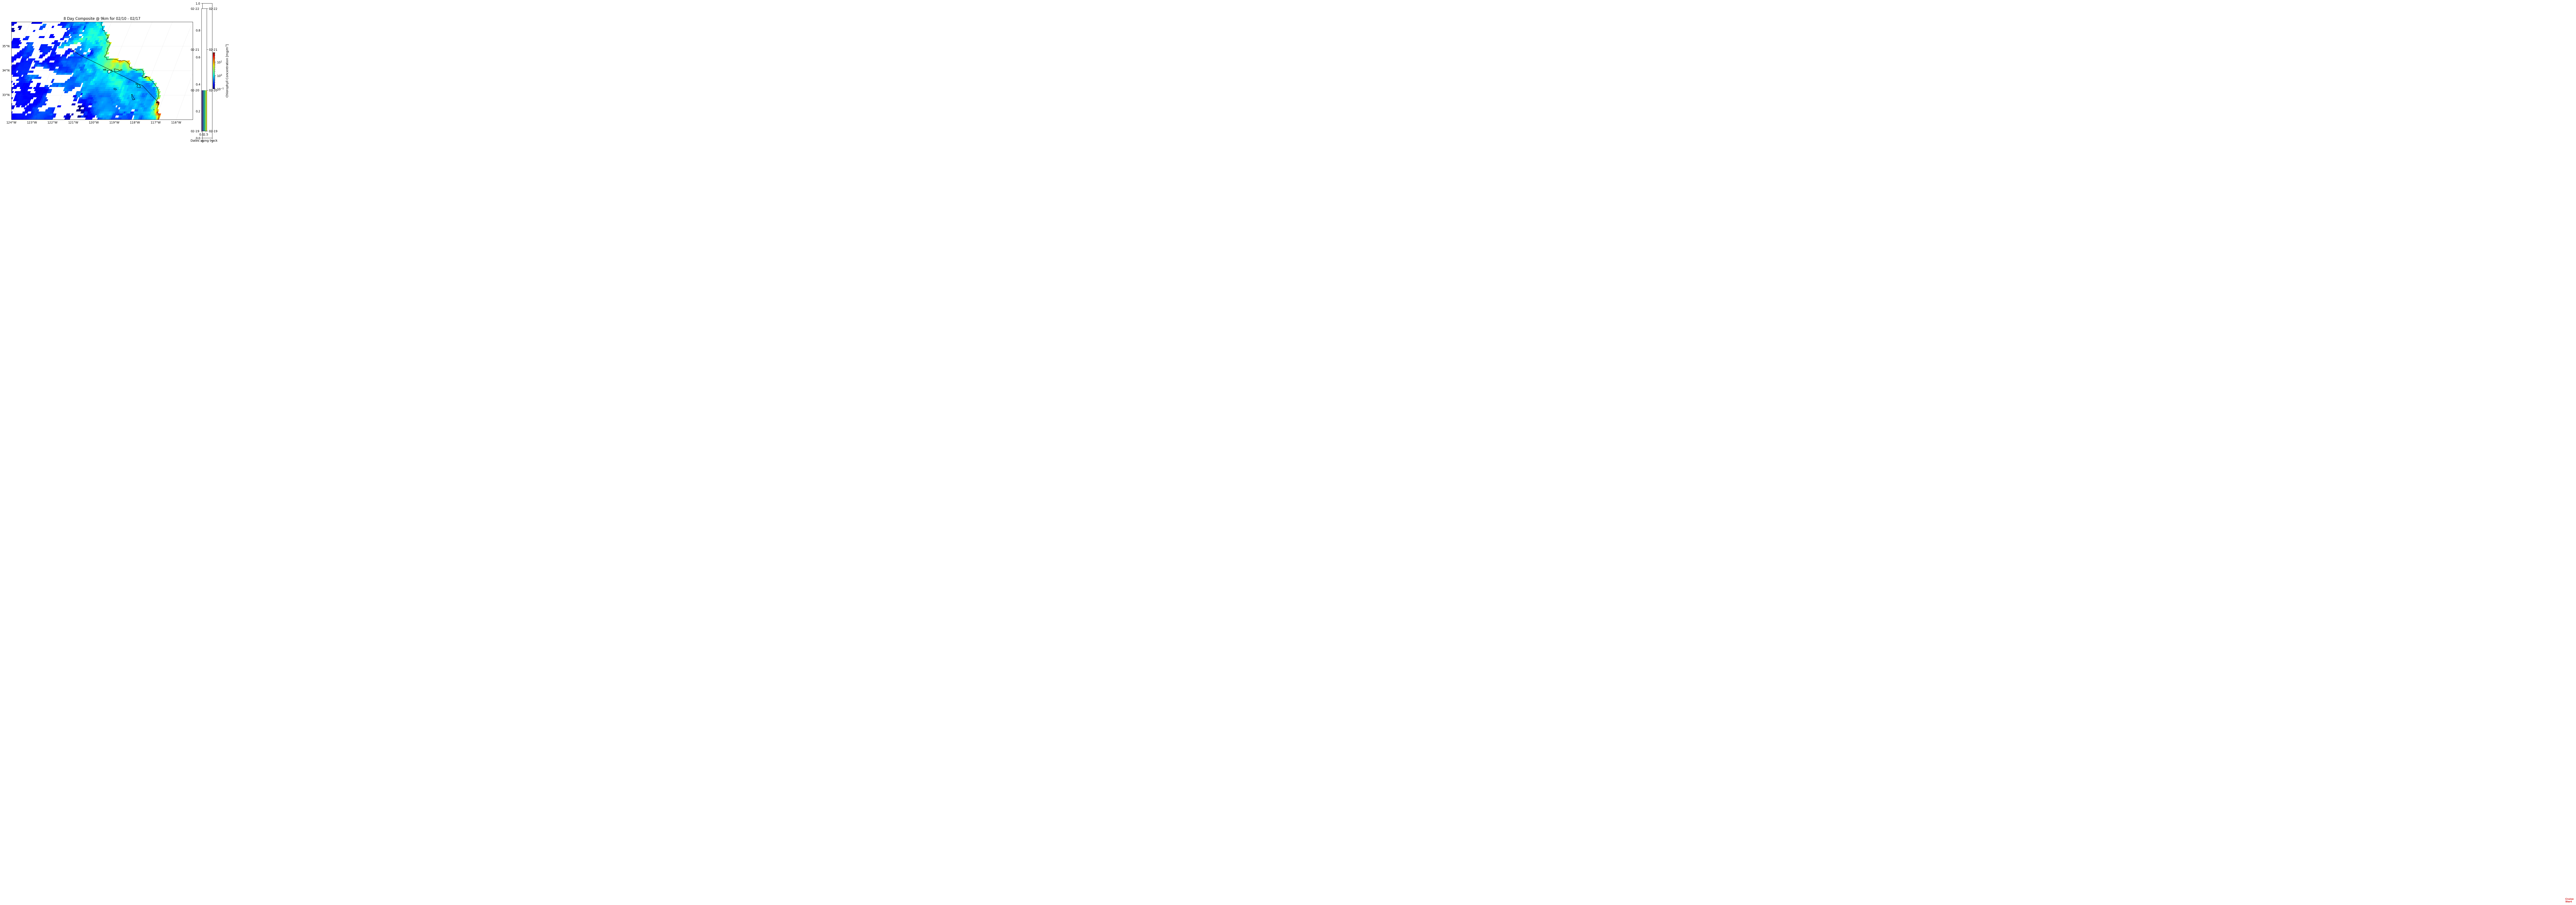

In [50]:
import matplotlib.gridspec as gridspec

# use most recent saved chl map and ship track 
# inset the daily chl from sat at bottom 

dataset = xr.open_dataset(path+ff) 
chl = dataset["chlor_a"]
clon, clat = np.meshgrid(dataset["lon"], dataset["lat"])

crs_proj = cartopy.crs.Robinson()
crs_data = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1,2,width_ratios=[15,1],wspace=0.1)
ax = fig.add_subplot(gs[0],projection=crs_proj)

# mesh = ax.pcolormesh(lon, lat, chl, cmap="jet", transform=crs_data) #, vmin=chl_extent[0], vmax=chl_extent[1])
mesh = ax.pcolormesh(clon,clat,chl,cmap='jet',transform=crs_data,norm=mcolors.LogNorm(vmin=chl_extent[0],vmax=chl_extent[1]) )

cbar_ax = fig.add_subplot(gs[1])
cbar = plt.colorbar(mesh, ax=cbar_ax, orientation='vertical') #, fraction=0.046, pad=0.02)
cbar.set_label(r'Chlorophyll Concentration [mg/$m^3$]')
ax.set_extent((xmin,xmax,ymin,ymax))
ax.coastlines()

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.2, linestyle='-')  
gl.top_labels = False; gl.right_labels = False 
gl.xlocator = mticker.MultipleLocator(1) 
gl.ylocator = mticker.MultipleLocator(1) 

d0 = datetime.strptime(dataset.attrs.get("product_name", ff)[11:19], "%Y%m%d")
d1 = datetime.strptime(dataset.attrs.get("product_name", ff)[20:28], "%Y%m%d")
ax.set_title(f'8 Day Composite @ 9km for {d0.strftime("%m/%d")} - {d1.strftime("%m/%d")}')

# add ship trajectory
numdays = np.arange(0,NN)
j = ax.plot(slons,slats,linewidth=1,label='Ship Track',color='k',transform=crs_data)
k = ax.scatter(slons,slats,c=numdays,s=4,linewidth=1,transform=crs_data)

j1 = ax.scatter(slons[0],slats[0],c='tab:red',marker='*',s=60,transform=crs_data)
ax.annotate('Cruise\nStart',(slons[0]-0.075,slats[0]-0.25),color='tab:red',fontsize=8,fontweight='bold')

# plt.legend()

# add colorbars for plot to show time of trajectory

'''
cax = fig.add_axes([0.825,0.075,0.015,0.4]) # [left, bottom, width, height]
timerange = np.linspace(ts[0],ts[-1],8)
dates = [datetime.datetime.utcfromtimestamp(d) for d in timerange]
dates = [datetime.datetime.strftime(d,'%m-%d') for d in dates]
cbar = plt.colorbar(j,cax=cax,orientation='vertical',ticks=numdays) 
cax.tick_params(axis='both',which='both',left=False,right=True,labelright=False)
'''

# cax = fig.add_axes([0.845,0.075,0.015,0.4]) # [left, bottom, width, height]
cax2 = fig.add_axes([0.6, 0.15, 0.02, 0.7])  
dates = [dt.datetime.strftime(d,'%m-%d') for d in seadates]
cbar = plt.colorbar(k,cax=cax2,orientation='horizontal')
cax2.yaxis.set_ticks(numdays,labels=dates)
cax2.tick_params(axis='both',which='both',right=True,left=False,labelright=True)
cbar.set_label('Dates along track',labelpad=10,fontsize=10)
#cax.xaxis.set_ticks_position('top') 
#cax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.show()



Text(0.5, 0.98, 'Manually added subplots, spanning a column')

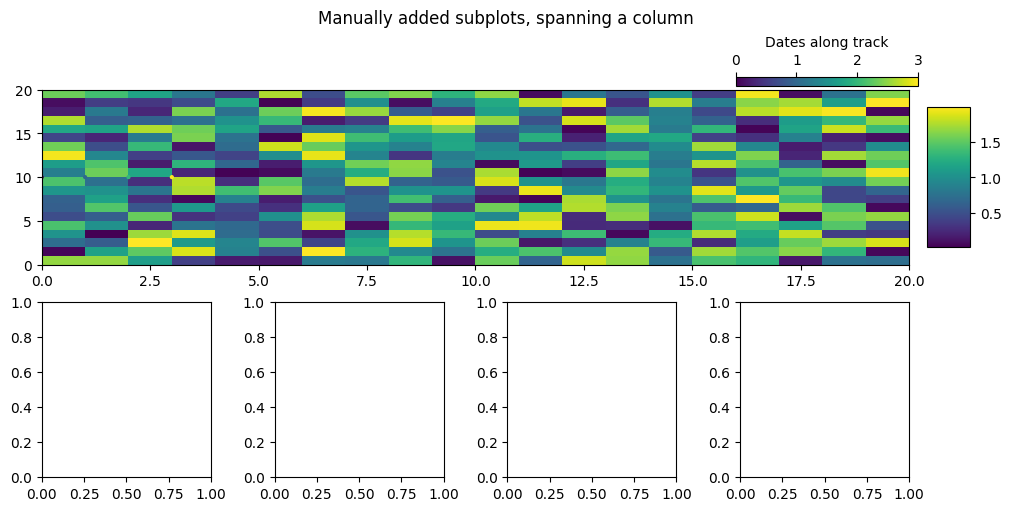

In [62]:
fig = plt.figure(figsize=(10,5), layout="constrained")
numdays = NN 
numday = np.arange(0,NN)
spec = fig.add_gridspec(2,numdays)

cmaps = ['RdBu_r', 'viridis']

# consolidate top row 
ax0 = fig.add_subplot(spec[0, :])
pcm = ax0.pcolormesh(np.random.random((20, 20)) * (col + 1),cmap=cmaps[1])
traj = ax0.scatter([0,1,2,3],[10,10,10,10],c=numday,s=4,linewidth=1)
# chl colorbar 
cax0 = ax0.inset_axes([1.02, 0.1, 0.05, 0.8]) # [left, bottom, width, height]
chlcbar = fig.colorbar(pcm, cax=cax0,orientation='vertical')
# trajectory colorbar
cax1 = ax0.inset_axes([0.8, 1.02, 0.21, 0.05]) # [left, bottom, width, height]
trajcbar = fig.colorbar(traj, cax=cax1,orientation='horizontal')
cax1.tick_params(axis='both',which='both',right=True,left=False,labelright=True)
cax1.xaxis.set_ticks_position('top'); cax1.xaxis.set_label_position('top') 
trajcbar.set_label('Dates along track',labelpad=5,fontsize=10)


for ii in np.arange(0,numdays) : 
    ax = fig.add_subplot(spec[1,ii])
    
fig.suptitle('Manually added subplots, spanning a column')

np.int64(2)

In [22]:
[f for f in sorted_files if fnmatch.fnmatch(f, '*20250220*DAY*9km*.nc')]

['AQUA_MODIS.20250220.L3m.DAY.CHL.chlor_a.9km.NRT.nc']

In [13]:
day9kmfile = [f for f in sorted_files if fnmatch.fnmatch(f, f'*{datenum}*DAY*9km*.nc')]
day9kmfile

[]

In [ ]:

fig, axs = plt.subplots(2, 2)
cmaps = ['RdBu_r', 'viridis']
for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        pcm = ax.pcolormesh(np.random.random((20, 20)) * (col + 1),
                            cmap=cmaps[col])
        fig.colorbar(pcm, ax=ax)



In [ ]:
fig, axs = plt.subplots(3, 3, layout='constrained')
for ax in axs.flat:
    pcm = ax.pcolormesh(np.random.random((20, 20)))

fig.colorbar(pcm, ax=axs[0, :2], shrink=0.6, location='bottom')
fig.colorbar(pcm, ax=[axs[0, 2]], location='bottom')
fig.colorbar(pcm, ax=axs[1:, :], location='right', shrink=0.6)
fig.colorbar(pcm, ax=[axs[2, 1]], location='left')

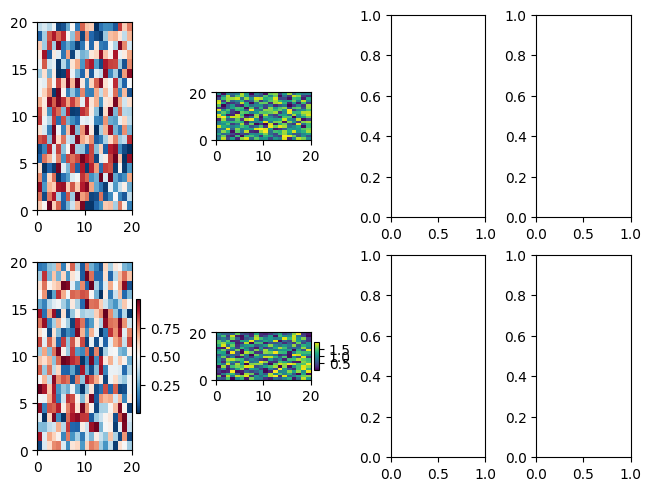

In [52]:
numdays = NN 

fig, axs = plt.subplots(2, numdays, layout='constrained')
gs = axs[0, 2].get_gridspec()
# remove top axes to aggregate into 1 subplot for map 


cmaps = ['RdBu_r', 'viridis']

for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        pcm = ax.pcolormesh(np.random.random((20, 20)) * (col + 1),
                            cmap=cmaps[col])
        if col == 0:
            ax.set_aspect(2)
        else:
            ax.set_aspect(1/2)
        if row == 1:
            cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6])
            fig.colorbar(pcm, cax=cax)

In [ ]:
fig = plt.figure(layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.5, 1.])
axs0 = subfigs[0].subplots(2, 2)
subfigs[0].set_facecolor('lightblue')
subfigs[0].suptitle('subfigs[0]\nLeft side')
subfigs[0].supxlabel('xlabel for subfigs[0]')

axs1 = subfigs[1].subplots(3, 1)
subfigs[1].suptitle('subfigs[1]')
subfigs[1].supylabel('ylabel for subfigs[1]')
